
# <p style="text-align: center;">EE 380L: Data Mining</p>
# <p style="text-align: center;">Assignment 2</p>
## <p style="text-align: center;">Total points: 72</p>
## <p style="text-align: center;">Due: Tuesday, February 22nd, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTID for both students.  Homework groups will be created and managed through Canvas, so please do not arbitrarily change your homework group.  

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

## <p style="color:red"> Osman Fatih Kilic </p>
## <p style="color:red"> UT EID: ok2439 </p>

# Question 1: Ridge and Lasso Regression (20 points)
Use the following code to import the dow_jones dataset.

In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('dow_jones_index.data')
df = df.dropna()
X = df[[u'open', u'high', u'low', u'close',
       u'volume', u'percent_change_price',
       u'percent_change_volume_over_last_wk', u'previous_weeks_volume', u'next_weeks_close',
       u'percent_change_next_weeks_price', u'days_to_next_dividend',
       u'percent_return_next_dividend']]
X = X.as_matrix()

for feat in range(X.shape[1]):
    try:
        if "$" in X[0, feat]:
            X[:,feat] = [i.split("$")[1] for i in X[:,feat]]
    except:
        pass
X = X.astype('float')
X = (X - np.mean(X, axis=0))/np.std(X, axis=0)

y = df[[u'next_weeks_open']]
y = y.as_matrix()
y = [i.split("$")[1] for i in y[:, 0]]
y = np.array(y)
y = y.astype('float')

You will reuse the same dataset that you used in HW1. In this HW, you will add additional second-order polynomial and interaction variables to the features matrix. Note that this code adds all combinations of the features with degree less than or equal to two; in practice one may introduce only a few based on domain knowledge or experimentation.

In [3]:
from sklearn.preprocessing import PolynomialFeatures
X = PolynomialFeatures(2, include_bias=False).fit_transform(X)

In this question, you will explore the application of Lasso and Ridge regression using sklearn package in Python. The following code will split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 20** and **test_size = 0.33**.  Note: lambda is called alpha in sklearn.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=20)

1) Use sklearn.linear_model.Lasso and sklearn.linear_model.Ridge classes to do a [5-fold cross validation](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py) using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). For the sweep of the regularization parameter, we will look at a grid of values ranging from $\lambda = 10^{6}$ to $\lambda = 10^{-2}$. In Python, you can consider this range of values as follows:

      import numpy as np

      alphas =  10**np.linspace(6,-2,100)*0.5

  Report the best chosen $\lambda$ based on cross validation on each model. The cross validation should happen on your training data using  average MSE as the scoring metric. (5pts)

2) Run ridge and lasso for all of the alphas specified above (on training data), and plot the coefficients learned for each of them - there should be one plot each for lasso and ridge, so a total of two plots; the plots for different features for a method should be on the same plot (e.g. Fig 6.6 of JW). What do you qualitatively observe when value of the regularization parameter is changed? What do you observe about the coefficients returned from the ridge and lasso models? (5pts)


3) What are the top 10 most important features for the lasso and ridge models for the hyperparameters that got the best MSE? (2pts)


4) SKLearn can perform this cross validation for us and choose the best regularization hyper-parameter. It will automatically determine the range of $\lambda$ s to search over. Run lasso again with cross validation using [sklearn.linear_model.LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). Set the cross validation parameters as follows:

    LassoCV(alphas=None, cv=10, max_iter=10000)

    Report the best $\lambda$ based on cross validation. (3 pts)
    
5) 
    i) Run Ridge, lasso with the best hyperparameters and report the MSE on test data. 
    ii) Run OLS on the training data with all the features and then with the features selected through lasso (features with non zero weights). Report the MSE on test data. (5 pts)

## Answer

### 1)
In this part we report best hyperparameters based on cross-validation and mean MSE.

In [5]:
from sklearn.model_selection import GridSearchCV
# Define the hyperparameter grid
alphas_grid =  10**np.linspace(6,-2,100)*0.5
n_folds = 5
# Run CV on ridge regression
model = linear_model.Ridge()
grid = GridSearchCV(model,param_grid=dict(alpha=alphas_grid),
                    scoring='neg_mean_squared_error',cv=n_folds,return_train_score=True)
grid.fit(X_train,y_train)
ridge_est = grid.best_estimator_
ridge_results = pd.DataFrame.from_dict(grid.cv_results_)
param_ridge = ridge_results['param_alpha'].iloc[ridge_results['mean_test_score'].idxmax()]
print 'Best chosen param by Ridge: {}'.format(param_ridge)
# Run CV on lasso regression
model = linear_model.Lasso(max_iter=10000)
grid = GridSearchCV(model,param_grid=dict(alpha=alphas_grid),
                    scoring='neg_mean_squared_error',cv=n_folds,return_train_score=True)
grid.fit(X_train,y_train)
lasso_est = grid.best_estimator_
lasso_results = pd.DataFrame.from_dict(grid.cv_results_)
param_lasso = lasso_results['param_alpha'].iloc[lasso_results['mean_test_score'].idxmax()]
print 'Best chosen param by Lasso: {}'.format(param_lasso)

Best chosen param by Ridge: 0.005
Best chosen param by Lasso: 0.00725414389248


 ### 2)
Now, we will observe how the coefficients we find change along with the regularization parameter over different models.

In [6]:
ridge_coeff = list()
lasso_coeff = list()
for alpha_selected in alphas_grid:
    # Ridge regression
    ridge = linear_model.Ridge(alpha=alpha_selected)
    ridge.fit(X_train,y_train)
    ridge_coeff.append(ridge.coef_)
    # Lasso regression
    lasso = linear_model.Lasso(alpha=alpha_selected,max_iter=10000)
    lasso.fit(X_train,y_train)
    lasso_coeff.append(lasso.coef_)

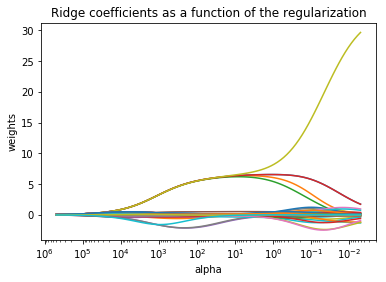

In [7]:
# Display the results for the ridge regularization
ax = plt.gca()
ax.plot(alphas_grid, ridge_coeff)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

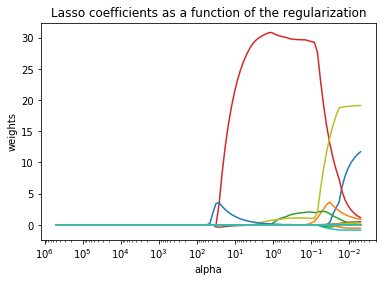

In [8]:
# Display the results for the ridge regularization
ax = plt.gca()
ax.plot(alphas_grid, lasso_coeff)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Note that when we impose high regularization on the models, almost every weight of the models are zeroed, thus we obtain low variance and high bias on these models. Then as we decrease the regularization parameter, we observe the weights of the model starts varying and we observe that the lower the regularization of the model the higher the variance of the weights we get.

Particularly, we observe that Lasso zeroes more elements of the model than the Ridge. We observe that the distriubtion of the weights of Ridge is smoother than the Lasso. Also, we observe that Lasso and Ridge return different models for the same level of regularization so that the important features are different for the two models.

### 3)

The top 10 important features for each model at best are as following.

In [43]:
lasso_est.fit(X_train,y_train)
ridge_est.fit(X_train,y_train)

Ridge(alpha=0.0050000000000000001, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [24]:
# Define function that return indices for a boolean function
def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

ind = lasso_est.coef_.argsort()
lasso_features = indices(ind, lambda x: x >= 80)
ind = ridge_est.coef_.argsort()
ridge_features = indices(ind,lambda x: x >= 80)

In [25]:
print 'Best 10 features chosen by Ridge: {}'.format(ridge_features)
print 'Best 10 features chosen by Lasso: {}'.format(lasso_features)

Best 10 features chosen by Ridge: [4, 14, 18, 37, 38, 41, 42, 46, 58, 73]
Best 10 features chosen by Lasso: [4, 24, 25, 26, 27, 28, 29, 30, 43, 44]


### 4)
Auto-CV for Lasso

In [28]:
model = linear_model.LassoCV(max_iter=10000,cv=10)
model.fit(X_train,y_train)
print 'Best chosen param by LassoCV over 10-fold: {}'.format(model.alpha_)

Best chosen param by LassoCV over 10-fold: 0.0466112165952


### 5)
#### i) We first run ridge and lasso over test data with determined hyperparameters

In [44]:
y_pred = lasso_est.predict(X_test)
lasso_mse = mean_squared_error(y_test,y_pred)
print 'Lasso MSE over test data: {}'.format(lasso_mse)
y_pred = ridge_est.predict(X_test)
ridge_mse = mean_squared_error(y_test,y_pred)
print 'Ridge MSE over test data: {}'.format(ridge_mse)

Lasso MSE over test data: 0.0360787946137
Ridge MSE over test data: 0.00193173303222


#### ii) 
We first run Ordinary Least Squares over training data using all of the features and calculate its MSE performance over test data. Second, we use only the features selected by lasso to perform the same operations.

In [45]:
ind = lasso_est.coef_>0
# Selected features datasets
X_train_modified = X_train[:,ind]
X_test_modified = X_test[:,ind]
# OLS over full feature-set
model = linear_model.LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
ols_full_mse = mean_squared_error(y_test,y_pred)
print 'OLS MSE using all features: {}'.format(ols_full_mse)
# OLS over selected features
model.fit(X_train_modified,y_train)
y_pred = model.predict(X_test_modified)
ols_selected_mse = mean_squared_error(y_test,y_pred)
print 'OLS MSE using selected features: {}'.format(ols_selected_mse)

(90,)
OLS MSE using all features: 0.000255408843495
OLS MSE using selected features: 0.188669602469


# Question 2: Bias-Variance Tradeoff (5 points)

1. Describe the relationship between Ordinary Least Squares and Ridge Regression (the problem analyzed in the previous question) with reference to Bias-Variance trade-off.
2. Which is a higher variance model, kNN with k = 1 or with k = 10?

# Answer

1) The $l_2$ norm regularization that Ridge regression introduces penalizes the variance of the model. Therefore, the more the regularization increases the less variance the Ridge regression model will have, which in turn will increase the bias. 

On the other hand, Ordinary Least Squares does not impose any constraint on the model, which in turn fits over the data in a way that minimizes the squared loss. Therefore, OLS model potentially will have higher variance than Ridge Regression, but lower bias.

2) kNN with k=1 will have a higher variance and lower bias than k=10. Note that k=10 averages using 10 reference points which reduces the variance compared to k=1.

# Question 3 - Principal Component Analysis (15 points)

Import the same dataset with the interaction variables as in Q1.

In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('dow_jones_index.data')
df = df.dropna()
X = df[[u'open', u'high', u'low', u'close',
       u'volume', u'percent_change_price',
       u'percent_change_volume_over_last_wk', u'previous_weeks_volume', u'next_weeks_close',
       u'percent_change_next_weeks_price', u'days_to_next_dividend',
       u'percent_return_next_dividend']]
X = X.as_matrix()

for feat in range(X.shape[1]):
    try:
        if "$" in X[0, feat]:
            X[:,feat] = [i.split("$")[1] for i in X[:,feat]]
    except:
        pass
X = X.astype('float')
X = (X - np.mean(X, axis=0))/np.std(X, axis=0)

y = df[[u'next_weeks_open']]
y = y.as_matrix()
y = [i.split("$")[1] for i in y[:, 0]]
y = np.array(y)
y = y.astype('float')

In [3]:
from sklearn.preprocessing import PolynomialFeatures
X = PolynomialFeatures(2, include_bias=False).fit_transform(X)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=20)

(a) Perform PCA using the sklearn [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) package.  Create i) a scree plot depicting the proportion of variance and ii) a cumulative proportion of variance explained by the principal components of the data (X_train matrix).  Refer to Figure 10.4 of JW for an example.  You may use the output attribute *explained variance ratio*. How many principal components (N1, N2, N3) are required to explain cumulative variance of 90%, 95%, and 99%, respectively? (6 pts)

(c) Fit an ordinary least squares linear regression using N1, N2, and N3 number of principal components, respectively. Fit PCA on X_train and predict on X_test. Compare the test MSE using N1, N2, N3 to using all features from PCA (6 pts)

(d) Compare this to the MSE reported in Q1.For this dataset, would you use PCA/Lasso as a feature elimination technique based on: (3 pts)
i) Interpretability of results
ii) MSE value
iii) Hyperparameter tuning?

## Answer

### (a) Find PVE of PCs

In [5]:
from sklearn import decomposition
model = decomposition.PCA()
model.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

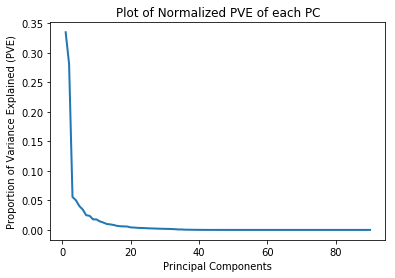

In [6]:
# Scree plot for each component PVE
indices = np.arange(np.size(model.components_,axis=1)) + 1
plt.plot(indices,model.explained_variance_ratio_,'-',linewidth=2)
plt.title('Plot of Normalized PVE of each PC')
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variance Explained (PVE)')
plt.show()

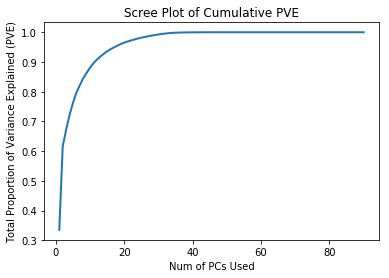

In [7]:
# Screeplot for the cumulative PVE of PCs
cum_pve = np.cumsum(model.explained_variance_ratio_)
indices = np.arange(np.size(model.components_,axis=1)) + 1
plt.plot(indices,cum_pve,'-',linewidth=2)
plt.title('Scree Plot of Cumulative PVE')
plt.xlabel('Num of PCs Used')
plt.ylabel('Total Proportion of Variance Explained (PVE)')
plt.show()

In [8]:
N1 = indices[cum_pve>0.9]
N1 = N1[0]
print 'Number of Principal Components used for 90% PVE: {}'.format(N1)

N2 = indices[cum_pve>0.95]
N2 = N2[0]
print 'Number of Principal Components used for 95% PVE: {}'.format(N2)

N3 = indices[cum_pve>0.99]
N3 = N3[0]
print 'Number of Principal Components used for 99% PVE: {}'.format(N3)

Number of Principal Components used for 90% PVE: 12
Number of Principal Components used for 95% PVE: 18
Number of Principal Components used for 99% PVE: 29


### (b) Fit OLS using PCs

In [9]:
# OLS Using All PCs
model = decomposition.PCA()
X_train_reduced = model.fit_transform(X_train)
X_test_reduced = model.transform(X_test)
ols = linear_model.LinearRegression()
ols.fit(X_train_reduced,y_train)
y_pred = ols.predict(X_test_reduced)
all_mse = mean_squared_error(y_test,y_pred)
print 'MSE of OLS using All PCs: {}'.format(all_mse)


# OLS Using N1 PCs
model = decomposition.PCA(n_components=N1)
X_train_reduced = model.fit_transform(X_train)
X_test_reduced = model.transform(X_test)
ols = linear_model.LinearRegression()
ols.fit(X_train_reduced,y_train)
y_pred = ols.predict(X_test_reduced)
N1_mse = mean_squared_error(y_test,y_pred)
print 'MSE of OLS using {} PCs: {}'.format(N1,N1_mse)

# OLS Using N2 PCs
model = decomposition.PCA(n_components=N2)
X_train_reduced = model.fit_transform(X_train)
X_test_reduced = model.transform(X_test)
ols = linear_model.LinearRegression()
ols.fit(X_train_reduced,y_train)
y_pred = ols.predict(X_test_reduced)
N2_mse = mean_squared_error(y_test,y_pred)
print 'MSE of OLS using {} PCs: {}'.format(N2,N2_mse)

# OLS Using N2 PCs
model = decomposition.PCA(n_components=N3)
X_train_reduced = model.fit_transform(X_train)
X_test_reduced = model.transform(X_test)
ols = linear_model.LinearRegression()
ols.fit(X_train_reduced,y_train)
y_pred = ols.predict(X_test_reduced)
N3_mse = mean_squared_error(y_test,y_pred)
print 'MSE of OLS using {} PCs: {}'.format(N3,N3_mse)

MSE of OLS using All PCs: 0.000255408822051
MSE of OLS using 12 PCs: 145.469202378
MSE of OLS using 18 PCs: 27.7258861025
MSE of OLS using 29 PCs: 3.19815659743


### (c) Comments on the results and dimensionality reduction methods
(i)
We lose the interpretability of features when we use PCA since it transforms the features we have using linear combinations. On the other hand Lasso feature selection does not transform the feature, but merely selects the ones that we have. Therefore, it preserves the interpretability of the feature selection process. We can also infer which features are more important in solving the problem and collect the further data accordingly if we have to.

(ii) 
Note that if we seperate training and testing features during PCA, this method works worse than Lasso feature selection in terms of dimensionality reduction and MSE. Lasso selects 11 features while N1=12 and Lasso selected features perform better with OLS. Since PCA is an unsupervised feature reduction method, while Lasso is a supervised method and actually considers the model's performance when selecting features, the result of Lasso selection working better is expected.


(iii) PCA do not require any hyperparameter tuning since it is an unsupervised method, while Lasso requires it. Therefore, it can be easy to implement PCA.

# Question 4 - Sampling (3+2=5pts)

1 . Your firm is conducting a customer survey for a new product. You are tasked with estimating whether the product will be liked or disliked by the entire market. Unfortunately, you cannot reach all the customers. So you randomly sample 400 participants and ask them "Will you like the product" as a question. The responses are evenly split. But you attended a Data Mining course, so you know the estimate is not simply 50%. 
   
What are the lower and upper bounds of probability corresponding to a confidence of 99% ($\alpha = 0.99$)?


2 . Your manager asks you to halve the probability range you reported in part 1. This can be accomplished in two different ways:

    a) Reduce the confidence without going below 90%. 
    OR
    b) Conduct a new survey to acquire more samples. In this case let us assume that the results are again evenly split.
    
Which option is viable? If a), what is the highest confidence you can use? And if b), how many samples do you need?

## Answer

### 1.
In order to find $99%$ confidence interval (C.I.), we need to find the central $0.99$ probability interval under the hypothesis $\hat{p}=1/2$. $0.99%$ of the probability is within $\pm 2.58\sigma$ of the mean $1/2$. Therefore, we find the confidence interval using 400 samples as
$$C_l = 1/2 - 2.58\sqrt{\frac{1/4}{400}} = 0.4355$$
$$C_u = 1/2 + 2.58\sqrt{\frac{1/4}{400}} = 0.5645.$$
We conclude the C.I. as $[C_l,C_u] = [0.4355,0.5645]$

### 2.

From the derivations in part 1, we can see that in order to halve the confidence range we either have to collect $1600$ samples or decrease the confidence level so that we will aim for a z-score of $1.29$.

$\pm 1.29\sigma$ range of the mean cover $80.03%$ of the probability, which is the highest confidence we can use in order to halve the range in part 1.

Therefore, we cannot halve the range without going below $90%$ confidence. Hence the option (b) is viable with $\textbf{1600 samples collected}$. 

# Question 5: Ridge and Lasso Regression (15 points)
The ridge regression problem is characterized by the following loss function:
$$\mathcal{L}(\beta) = ||X \beta - y||_2^2 + \lambda ||\beta||^2_2$$

The ridge regression problem is the case where the penalty term ($\lambda ||\beta||$) uses the squared l-2 norm ($\lambda ||\beta||^2$).

a) Find the closed form solution to the ridge regresion problem
$$\underset{\beta}{\mathrm{argmin}} \mathcal{L}(\beta)$$
where $\mathcal{L}(\beta)$ is the loss function above.

b) Now given the SVD of $X$ as $U \Sigma V^T$, express $X \hat \beta_{ridge}$ in terms of $U$, $V$ and $\Sigma$

c) Explain what the expression for $X \hat \beta_{ridge}$ derived above tells us about how the addition of the regularization term affects the solution. (Hint: think about $\lambda ||\beta||^2$ as a penalty term)

# Answer

### (a)
$$\frac{\partial}{\partial \beta}L(\beta) = 2(X\beta-y)^T X + 2\lambda \beta^T = 0$$

$$\Rightarrow \beta^T X^T X - y^T X + \lambda \beta^T = 0 $$

$$\Rightarrow (X X^T + \lambda I)\beta = X^T y$$

$$\Rightarrow \beta_{ridge} = (X X^T + \lambda I)^{-1}X^T y$$

### (b)
$$X\beta = X (X^T X + \lambda I)^{-1}X^T y$$
Using matrix inversion lemma we can write
$$X\beta = (I + \frac{1}{\lambda}X^T X)^{-1}y$$
and since $X = U \Sigma V^T$, then we get
$$X\beta = (I + \frac{1}{\lambda}V \Sigma U^T U \Sigma V^T )^{-1}y.$$
Note that $U$ is orthonormal matrix, thus $U^T U = I$, which gives us
$$X\beta_{ridge} = (I + \frac{1}{\lambda}V \Sigma^2 V^T )^{-1}y.$$



### (c)
As we can see from the expression above, the regularization actually stabilizes the model by adding the identity matrix. Larger $\lambda$ (regularization) means that the information coming from the data will have less effect on the model. Note that as we increase $\lambda$, the term $V \Sigma^2 V^T$ (which actually includes the information we obtain from the data) gets smaller with respect to the identity matrix, which means that the model becomes more irrelevant from the data and actually gets closer to the $l_2$ norm ball (unit circle).

# Question 6 - Outliers and Huber Loss (12 pts)

In this problem, we will use the same data set from the previous problem set to fit a linear model to the data using a Huber loss function rather than the l-2 norm usually used in OLS. sklearn has a nice API you can use: [http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn-linear-model-huberregressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn-linear-model-huberregressor)

Below is a snippet from the previous problem set to help you get started. For this problem, the only independent variable will be the "percent\_change\_price" feature.


In [52]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

df = pd.read_csv('dow_jones_index.data')
stock = df[["percent_change_price", "next_weeks_open"]]
stock = stock.dropna()
stock = stock.as_matrix()[1:]
stock[:, 1] = [i.split("$")[1] for i in stock[:, 1]]
stock = stock.astype('float')
stock[:, 0] = (stock[:, 0] - np.mean(stock[:, 0], axis=0))/np.std(stock[:, 0], axis=0)

X = stock[:,:1]
y = stock[:, 1]
X_train = X[:400,]
y_train = y[:400]

X_test = X[400:,]
y_test = y[400:,]

clf_train = linear_model.LinearRegression()
clf_train.fit(X_train, y_train)
predictions_train = clf_train.predict(X_train)
mse_train = mean_squared_error(y_train, predictions_train)
print('MSE train: ', mse_train)

predictions_test = clf_train.predict(X_test)
mse_test = mean_squared_error(y_test, predictions_test)
print('MSE test: ', mse_test)

('MSE train: ', 953.53804282290798)
('MSE test: ', 1192.1733687430108)


a) Now do the same for the Huber loss function and print the test and train MSE. Use a regularization coefficient of 0. (5 pts)

In [53]:
# ANSWER
model = linear_model.HuberRegressor(alpha=0)
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train,y_pred_train)
print('MSE train: ', mse_train)

y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test,y_pred_test)
print('MSE test: ', mse_test)

('MSE train: ', 969.07508822004024)
('MSE test: ', 1235.9698312114529)


Now let's artificially introduce some errors intro the train set:

In [54]:
y_train_outliers = np.copy(y_train)
y_train_outliers[0] = 10000.0

Note that we would never actually do this in a real application, this is simply for demo purposes.

b) Now create two models as before, but using the new y vector during training (one model using OLS and another using the Huber loss). Print the test and train MSE. Use a regularization coefficient of 0. (5 pts)

In [56]:
# ANSWER
# First we train linear regressor using Huber Loss
model = linear_model.HuberRegressor(alpha=0)
model.fit(X_train,y_train_outliers)
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train_outliers,y_pred_train)
print('Huber Loss - MSE train: ', mse_train)
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test,y_pred_test)
print('Huber Loss - MSE test: ', mse_test)
# Now we train linear regress using squared loss
model = linear_model.LinearRegression()
model.fit(X_train,y_train_outliers)
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train_outliers,y_pred_train)
print('Squared Loss - MSE train: ', mse_train)
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test,y_pred_test)
print('Squared Loss - MSE test: ', mse_test)

('Huber Loss - MSE train: ', 248826.75026848132)
('Huber Loss - MSE test: ', 1232.5469165949833)
('Squared Loss - MSE train: ', 246073.32477878802)
('Squared Loss - MSE test: ', 3570.0506399276815)


c) Explain the difference in prediction performance of the two models in these two scenarios (one without significant outliers in the data, and the other with a single outlier). (2 pts)

Note that training error is lower when we used squared loss, but the test error is higher. This is because the linear regressor with squared loss is overfitting over the outlier. Since the outlier creates the highest error over squared loss, linear model tries to lower this error the most by memorizing that point. Since it overfits over training data it performs better on training data, but poorly on test data.

On the other hand, for high error values Huber loss does not grow exponentially, but grows linearly. Therefore, the linear model with Huber loss does not put as much weight to reduce the error of the outlier. Thus it does not memorize the outlier, but learns the general underlying model of the data. Since it learns the general underlying model, it performs better over test data where there is no outlier but performs worse than squared loss model over training data